In [1]:
%load_ext line_profiler
%load_ext autoreload

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.special import expit as sigmoid
from scipy.stats import norm
from scipy import integrate

import tqdm.notebook as tqdm

In [73]:
P = 5000
d = 1

# mu = np.random.randn(d)
# Sigma = np.random.randn(d,d)
# Sigma = Sigma @ Sigma.T / d  

mu = np.zeros(d)
Sigma = np.eye(d)

x = np.random.multivariate_normal(mu, Sigma, P)

a0 = np.random.randn(d)
a0 = np.sqrt(d) * a0 / np.linalg.norm(a0)

In [157]:
c = 3 #inverse std of logistic noise
y = np.random.binomial(1, sigmoid(c * x @ a0 / np.sqrt(d)))*2 - 1 #scaled heaviside of logistic noise

In [158]:
V = y[:,None] * x@a0 / np.sqrt(d)

In [188]:
lamb = 1e-6
eta = lambda m: np.maximum(0, 1-m)
H = lambda a: np.mean(eta(y[:,None] * x @ a/np.sqrt(d)), 0) + lamb*(a**2).sum(0)

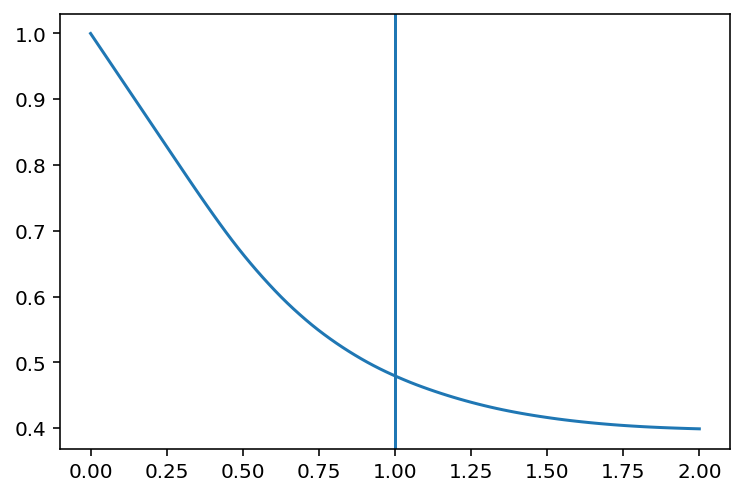

In [189]:
grid = np.linspace(-0,2,100).reshape(1, -1)
plt.plot(grid[0,:], H(grid))
plt.axvline(a0)

In [90]:
grid

array([[0.        , 0.02020202, 0.04040404, 0.06060606, 0.08080808,
        0.1010101 , 0.12121212, 0.14141414, 0.16161616, 0.18181818,
        0.2020202 , 0.22222222, 0.24242424, 0.26262626, 0.28282828,
        0.3030303 , 0.32323232, 0.34343434, 0.36363636, 0.38383838,
        0.4040404 , 0.42424242, 0.44444444, 0.46464646, 0.48484848,
        0.50505051, 0.52525253, 0.54545455, 0.56565657, 0.58585859,
        0.60606061, 0.62626263, 0.64646465, 0.66666667, 0.68686869,
        0.70707071, 0.72727273, 0.74747475, 0.76767677, 0.78787879,
        0.80808081, 0.82828283, 0.84848485, 0.86868687, 0.88888889,
        0.90909091, 0.92929293, 0.94949495, 0.96969697, 0.98989899,
        1.01010101, 1.03030303, 1.05050505, 1.07070707, 1.09090909,
        1.11111111, 1.13131313, 1.15151515, 1.17171717, 1.19191919,
        1.21212121, 1.23232323, 1.25252525, 1.27272727, 1.29292929,
        1.31313131, 1.33333333, 1.35353535, 1.37373737, 1.39393939,
        1.41414141, 1.43434343, 1.45454545, 1.47

In [54]:
if d == 1:
    h1 = plt.hist(x[np.sign(V-1) == 1], density=True, bins=100, alpha=.8)
    h2 = plt.hist(x[np.sign(V-1) == -1], density=True, bins=100, alpha=.8)

In [55]:
loc = a0 @ mu / np.sqrt(d)
scale = np.sqrt(a0.T @ Sigma @ a0 / d)
p = lambda x: sigmoid(c * x) * (norm.pdf(x, loc=loc, scale=scale) + norm.pdf(x, loc=-loc, scale=scale))

Text(0.5, 1.0, 'PDF of $V = y a_0^T x / \\sqrt{d}$')

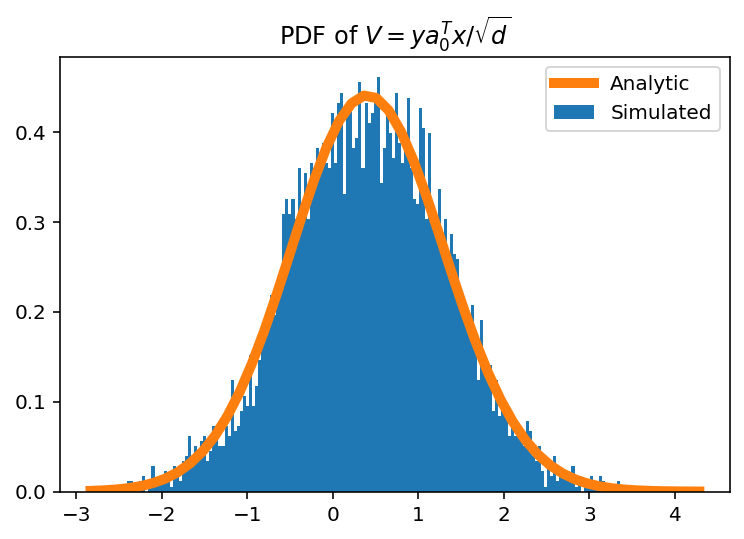

In [56]:
hist = plt.hist(V, bins=200, density=True, label='Simulated')

grid = np.linspace(min(V),max(V))
plt.plot(grid, p(grid), lw=5, label='Analytic')

plt.legend()
plt.title(r'PDF of $V = y a_0^T x / \sqrt{d}$')

In [57]:
from scipy.stats import rv_continuous

In [58]:
class VDistribution(rv_continuous):
    def __init__(self, loc, scale, c, name='VDistribution'):
        super().__init__(a=-np.inf, b=np.inf)
        
        self.loc = loc
        self.scale = scale
        self.c = c
        
    def _pdf(self, x):
        return sigmoid(self.c * x) * (norm.pdf(x, loc=self.loc, scale=self.scale) + norm.pdf(x, loc=-self.loc, scale=self.scale))

In [9]:
V = VDistribution(loc, scale, c)
Z = norm(0, 1)

In [10]:
def f1(alpha, sigma, gamma):
    """
        P(αV +σZ ≤ 1−γ)
    """
    return V.expect(lambda v: Z.cdf((1-gamma)/sigma - alpha/sigma * v))

def f2(alpha, sigma):
    """
        P(αV +σZ ≥1)
    """
    return V.expect(lambda v: 1 - Z.cdf(1/sigma - alpha/sigma * v))

def f3(alpha, sigma, gamma):
    """
        E[ ((1 − (αV + σZ)) / γ)^2  * I[1−γ ≤ αV +σZ ≤ 1] ]
    """
    return V.expect(
        lambda v: Z.expect(
            lambda z: ((1 - (alpha*v + sigma*z)) / gamma)**2, lb = (1-gamma-alpha*v)/sigma, ub = (1-alpha*v)/sigma
        )
    )

def g1(lamb, gamma, delta):
    return (2*lamb*gamma-1)*delta+1

def g2(sigma, gamma, delta):
    return delta*(sigma/gamma)**2


In [11]:
def eq1(alpha, sigma, gamma, delta, lamb):
    return f1(alpha, sigma, gamma) + f2(alpha, sigma) - g1(lamb, gamma, delta)

def eq2(alpha, sigma, gamma, delta, lamb):
    return f1(alpha, sigma, gamma) + f3(alpha, sigma, gamma) - g2(sigma, gamma, delta)

In [34]:
def train_loss(alpha, sigma, gamma):
    return V.expect(
        lambda v: Z.expect(
            lambda z: 1 - gamma - alpha*v - sigma*z, ub=(1-gamma-alpha*v)/sigma
        )
    ) 

def test_loss(alpha, sigma):
    """
        The paper gives no expression for this. This is a guess.
    """
    return V.expect(
        lambda v: Z.expect(
            lambda z: 1 - alpha*v - sigma * z, ub=(1-alpha*v)/sigma
        )
    ) 

In [13]:
from scipy import optimize

In [13]:
cons = [{'type':'eq', 'fun': lambda p: eq1(*p, delta, lamb)}, {'type':'eq', 'fun': lambda p: eq2(*p, delta, lamb)}]

In [14]:
def obj(p):
    alpha, sigma, gamma = p
    
    return V.expect(
        lambda v: Z.expect(
            lambda z: 1 - gamma - alpha*v - sigma * z, ub=(1-gamma-alpha*v)/sigma
        )
    ) + lamb*delta*(sigma**2 + alpha**2)

In [25]:
lamb = 1e-6
delta = 1

gamma = .42
sigma = .40
alpha = .28

res = optimize.minimize(obj, (alpha, sigma, gamma), constraints=cons, options={'disp': True, 'iprint':5})

In [30]:
res = optimize.minimize(obj, (alpha, sigma, gamma), constraints=cons, options={'disp': True, 'iprint':5})

  NIT    FC           OBJFUN            GNORM
    1     5     4.358163E-01     9.599593E-01
    2    10     1.516688E-01     3.272701E-01
    3    15     6.525207E-01     6.062151E-01
    4    21     1.981698E-01     2.290310E-01
    5    28     1.285431E-01     1.757121E-01
    6    38     1.102643E-01     1.834948E-01
    7    47     1.178251E-01     2.060193E-01
    8    59     1.421333E-01     2.101416E-01
    9    70     1.432338E-01     2.141866E-01
   10    80     1.252887E-01     2.141941E-01
   11    91     1.237863E-01     2.103820E-01
   12   105     1.231892E-01     2.103429E-01
   13   118     1.233136E-01     2.106680E-01
   14   132     1.244867E-01     2.107488E-01
   15   146     1.245198E-01     2.108460E-01
   16   159     1.222945E-01     2.105007E-01
   17   172     1.267470E-01     2.111521E-01
   18   187     1.267215E-01     2.110797E-01
   19   199     1.191585E-01     2.103327E-01
   20   211     1.424969E-01     2.109570E-01
   21   223     1.419828E-01     2

In [31]:
alpha, sigma, gamma = res.x

In [32]:
res

     fun: 92.21625493086114
     jac: array([-0.00939465,  0.01675129,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 344
     nit: 37
    njev: 37
  status: 0
 success: True
       x: array([ -4697.67759393,   8375.44507202, 180522.21918636])

In [34]:
train_loss(alpha, sigma, gamma)

5.685081005498913e-76

In [41]:
test_loss(alpha, sigma)

5450.067883563061

In [35]:
sigma

8375.445072016426

In [36]:
gamma

180522.21918635536

In [38]:
1 - gamma + alpha*1 + sigma * 1

-176843.45170826736

In [39]:
lamb*delta*(sigma**2 + alpha**2)

92.21625493086114

## Loop

In [35]:
lamb = 1e-6

deltas = np.linspace(.1, 2, 19)
deltas = np.concatenate((deltas, [1.0]))

results = []

for delta in tqdm.tqdm(deltas):
    
    #initial values
    gamma = 1
    sigma = 1
    alpha = 1

    def obj(p):
        alpha, sigma, gamma = p

        return V.expect(
            lambda v: Z.expect(
                lambda z: 1 - gamma - alpha*v - sigma * z, ub=(1-gamma-alpha*v)/sigma
            )
        ) + lamb*delta*(sigma**2 + alpha**2)
    
    cons = [{'type':'eq', 'fun': lambda p: eq1(*p, delta, lamb)}, {'type':'eq', 'fun': lambda p: eq2(*p, delta, lamb)}]
    out = optimize.minimize(obj, (alpha, sigma, gamma), constraints=cons, bounds = [(0, np.inf)]*3)
    alpha, sigma, gamma = out.x
    
    tr_ls = train_loss(alpha, sigma, gamma)
    te_ls = test_loss(alpha, sigma)
    

    result = {
        'lambda':lamb,
        'delta': delta,
        'gamma': gamma,
        'sigma': sigma,
        'alpha': alpha,
        'v_loc': loc,
        'v_scale': scale,
        'v_c': c,
        'train_loss': tr_ls,
        'test_loss': te_ls
    }
    results.append(result)
    
    print(result)

{'lambda': 1e-06, 'delta': 0.1, 'gamma': 0.5689218813944957, 'sigma': 0.9789767060979971, 'alpha': 2.6381828287741342, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 0.3127989921379428, 'test_loss': 0.49075103760042504}
{'lambda': 1e-06, 'delta': 0.20555555555555555, 'gamma': 2.6950758754008253, 'sigma': 2.500187582138391, 'alpha': 4.137638239111992, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 0.2115057068520797, 'test_loss': 0.7809681152983599}
{'lambda': 1e-06, 'delta': 0.3111111111111111, 'gamma': 68.21082203810803, 'sigma': 12.561218993378695, 'alpha': 12.77822375448966, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 9.385066375926944e-07, 'test_loss': 3.0457989782539974}
{'lambda': 1e-06, 'delta': 0.41666666666666663, 'gamma': 26.15887831347808, 'sigma': 5.301633338928415, 'alpha': 3.2535979153349843, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 1.0099900056720954e-06, 'test_loss': 1.7440706094529026}


/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2538: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals = integrate.quad(fun, lb, ub, **kwds)[0] / invfac
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2538: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  vals = integrate.quad(fun, lb, ub, **kwds)[0] / invfac


{'lambda': 1e-06, 'delta': 0.5222222222222223, 'gamma': 17369.572415225706, 'sigma': 7.198597898539781, 'alpha': 1.3449684369609622, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 0.0, 'test_loss': 2.9348125995738865}
{'lambda': 1e-06, 'delta': 0.6277777777777778, 'gamma': 124611.51710978357, 'sigma': 41.15739863643858, 'alpha': 5.774773210551813, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 0.0, 'test_loss': 15.05728758623001}
{'lambda': 1e-06, 'delta': 0.7333333333333333, 'gamma': 176447.1815786053, 'sigma': 0.548666332349321, 'alpha': 1.6529327852102071, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 0.0, 'test_loss': 0.452693991442784}


/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2538: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  vals = integrate.quad(fun, lb, ub, **kwds)[0] / invfac
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2538: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  vals = integrate.quad(fun, lb, ub, **kwds)[0] / invfac


{'lambda': 1e-06, 'delta': 0.8388888888888889, 'gamma': 394388.41640967585, 'sigma': 6964.056006287049, 'alpha': 31962.669953647724, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 1.9900004325550004e-59, 'test_loss': 2039.0147940281856}
{'lambda': 1e-06, 'delta': 0.9444444444444444, 'gamma': 407084.13397839817, 'sigma': 8677.864493472753, 'alpha': 42884.699446619394, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 3.2978430943164564e-29, 'test_loss': 2681.084554712019}
{'lambda': 1e-06, 'delta': 1.05, 'gamma': 261805.2937618403, 'sigma': 80.1012817971191, 'alpha': 1.3904716535722788, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 0.0, 'test_loss': 31.979284591293098}
{'lambda': 1e-06, 'delta': 1.1555555555555557, 'gamma': 283355.4867339359, 'sigma': 0.005116200378613309, 'alpha': 1.5616800783104972, 'v_loc': 0.0, 'v_scale': 1.0, 'v_c': 3, 'train_loss': 0.0, 'test_loss': 0.005387231509798193}



KeyboardInterrupt: 

In [1]:
import pandas as pd

In [3]:
result_df = pd.read_json(open('results/SVM_theoretical_gaussian_cov.json', 'r'))

In [4]:
# result_df = pd.DataFrame(results)

In [5]:
# result_df.to_json(open('results/SVM_theoretical_gaussian_cov.json', 'w'))

In [6]:
result_df

,lambda,delta,gamma,sigma,alpha,v_loc,v_scale,v_c,train_loss,test_loss
0,0.000001,0.100000,0.568922,0.978977,2.638183,0,1,3,3.127990e-01,0.490751
1,0.000001,0.205556,2.695076,2.500188,4.137638,0,1,3,2.115057e-01,0.780968
2,0.000001,0.311111,68.210822,12.561219,12.778224,0,1,3,9.385000e-07,3.045799
3,0.000001,0.416667,26.158878,5.301633,3.253598,0,1,3,1.010000e-06,1.744071
4,0.000001,0.522222,17369.572415,7.198598,1.344968,0,1,3,0.000000e+00,2.934813
5,0.000001,0.627778,124611.517110,41.157399,5.774773,0,1,3,0.000000e+00,15.057288
6,0.000001,0.733333,176447.181579,0.548666,1.652933,0,1,3,0.000000e+00,0.452694
7,0.000001,0.838889,394388.416410,6964.056006,31962.669954,0,1,3,1.990000e-59,2039.014794
8,0.000001,0.944444,407084.133978,8677.864493,42884.699447,0,1,3,3.297843e-29,2681.084555
9,0.000001,1.050000,261805.293762,80.101282,1.390472,0,1,3,0.000000e+00,31.979285


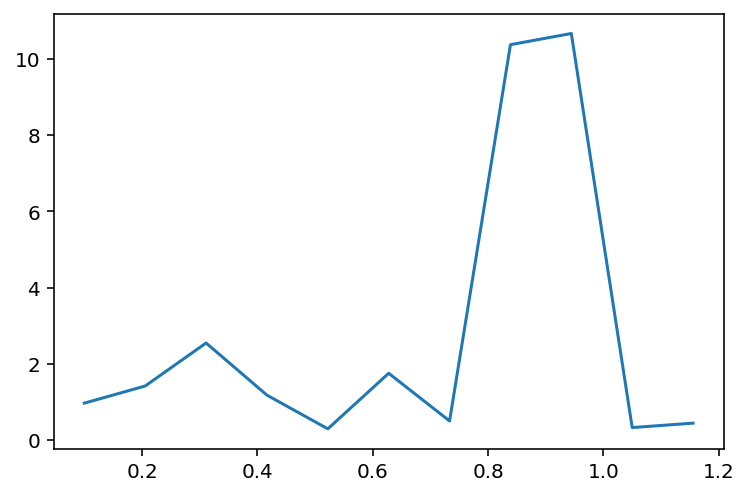

In [8]:
plt.plot(result_df.delta, np.log(result_df.alpha))

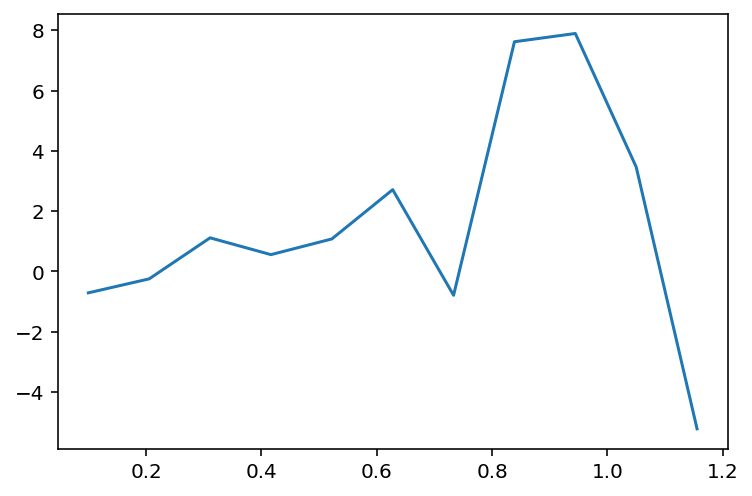

In [9]:
plt.plot(result_df.delta, np.log(result_df.test_loss))
# plt.plot(result_df.delta, result_df.train_loss)